In [2]:
import pandas as pd
import numpy as np
import dtale
import os 
os.chdir("..")

/Users/isaac/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/isaac/Library/Python/3.9/lib/python/site-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [48]:
tmp = pd.read_parquet("DATA/steam_data_clustered.parquet")
d = dtale.show(tmp)
print(d._main_url)

http://MacBook-Air-de-Isaac.local:40000/dtale/main/3


2025-12-16 13:54:19,327 - ERROR    - 127.0.0.1 - - [16/Dec/2025 13:54:19] code 400, message Bad request version ('\x91\x80\x9e»gÅæ1g:ã\x00*ªª\x13\x02\x13\x03\x13\x01À,À+Ì©À0À/Ì¨À')
2025-12-16 13:54:19,342 - ERROR    - 127.0.0.1 - - [16/Dec/2025 13:54:19] code 400, message Bad request version ('\x00\x00Å»ma\x80Ò&ol\x8eÿÄuÀ?')
2025-12-16 13:54:19,352 - ERROR    - 127.0.0.1 - - [16/Dec/2025 13:54:19] code 400, message Bad request version ('\x8dºÐÀKPJ\x00*ÊÊ\x13\x02\x13\x03\x13\x01À,À+Ì©À0À/Ì¨À')
2025-12-16 13:54:19,358 - ERROR    - 127.0.0.1 - - [16/Dec/2025 13:54:19] code 400, message Bad request version ('\x10K\x00*ºº\x13\x02\x13\x03\x13\x01À,À+Ì©À0À/Ì¨À')


In [41]:
df = pd.read_parquet("DATA/data.parquet")
cluster = pd.read_parquet("DATA/steam_data_clustered.parquet")
print(cluster.columns)

df = pd.merge( df, cluster, on="app_id")
del cluster

Index(['app_id', 'emb_0', 'emb_1', 'emb_2', 'emb_3', 'emb_4', 'emb_5', 'emb_6',
       'emb_7', 'emb_8',
       ...
       'type', 'tags_utilisateurs', 'cluster', 'cluster_KPCA',
       'cluster_KPCA90', 'cluster_BERTopic_K', 'cluster_BERTopic_K135',
       'cluster_BERTopic', 'cluster_id', 'cluster_name'],
      dtype='object', length=780)


In [42]:
emb_cols = [c for c in df.columns if c.startswith('emb_')]
df = df.loc[:, ~df.columns.str.startswith('emb')]
df = df.loc[:, ~df.columns.str.startswith('configuration')]
df = df.rename(columns={"donnees_commerciales_prix_initial":"prix"})

df["support_manette"] = df["support_manette"].astype(object)  # permet de mélanger strings et bool
df["support_manette"] = df["support_manette"].replace("full", True)
df["support_manette"] = df["support_manette"].fillna(False).infer_objects()
df["support_manette"] = df["support_manette"].astype(bool)  # conversion finale en bool

df["mois"] = df["date_de_sortie"].dt.month
df["mois_sin"] = np.sin(2 * np.pi * df["mois"] / 12)
df["mois_cos"] = np.cos(2 * np.pi * df["mois"] / 12)
df["succes"] = (
    (df["evaluations_avis_utilisateurs_pourcentage_positif"] > 85) &
    (df["evaluations_avis_utilisateurs_total"] > 500)
).astype("category")

df = df.drop(columns=['mois',"date_de_sortie",'nom', 'image', 'type_x', 'description_courte_x','description_courte_y',
       'description_detaillee', 'est_gratuit','developpeurs', 'editeurs','type_y','franchise','donnees_commerciales_prix_final','donnees_commerciales_devise','donnees_commerciales_pourcentage_reduction','evaluations_metacritic_score','evaluations_avis_utilisateurs_total_positif','evaluations_recommandations_total','evaluations_avis_utilisateurs_total_positif','evaluations_avis_utilisateurs_pourcentage_positif'])
d = dtale.show(df)
print(d._main_url)

/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_20675/1731458517.py:8: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



http://MacBook-Air-de-Isaac.local:40000/dtale/main/1


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np
# Algorithmes
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge

In [6]:
X = df[["support_manette","prix","contenu_et_fonctionnalites_nombre_succes",]].copy()
numeric_cols = ["prix", "contenu_et_fonctionnalites_nombre_succes"]
Y = df['evaluations_avis_utilisateurs_total']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


Test Base Line

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lr.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Linear Regression R2: -2.0083541927062853e-05
Linear Regression RMSE: 3142.3501429055486
                                    Feature        Coef
0                           support_manette  423.286016
2  contenu_et_fonctionnalites_nombre_succes   75.393784
1                                      prix    6.342361


In [8]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: -0.633087777795152
Random Forest RMSE: 4015.6419155674503


In [9]:
mlp = MLPRegressor(hidden_layer_sizes=(32,16), max_iter=2000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print("MLP R2:", r2_score(y_test, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))

MLP R2: 0.005764108537506529
MLP RMSE: 3133.2491677490684


In [9]:
# Colonnes catégorielles
categorical_cols = ["support_manette"]  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=5000,
    depth=6,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_train, y_train,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_test)

# Scores
print("CatBoost R2:", r2_score(y_test, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_catboost)))

0:	learn: 6061.6923559	total: 60.5ms	remaining: 5m 2s
500:	learn: 4639.9766829	total: 985ms	remaining: 8.85s
1000:	learn: 4343.7387659	total: 1.92s	remaining: 7.67s
1500:	learn: 4117.5546751	total: 2.85s	remaining: 6.66s
2000:	learn: 3979.1196499	total: 3.78s	remaining: 5.67s
2500:	learn: 3920.7035605	total: 4.71s	remaining: 4.7s
3000:	learn: 3879.7438470	total: 5.66s	remaining: 3.77s
3500:	learn: 3846.6938421	total: 6.58s	remaining: 2.82s
4000:	learn: 3823.9833239	total: 7.53s	remaining: 1.88s
4500:	learn: 3799.1774875	total: 8.46s	remaining: 938ms
4999:	learn: 3779.5266941	total: 9.39s	remaining: 0us
CatBoost R2: -0.4451759344403512
CatBoost RMSE: 3777.553075509544


Test avec logtransforme 

In [10]:
y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train_log)
y_pred_lr = lr.predict(X_test)
y_pred = np.expm1(y_pred_lr)
print("Linear Regression R2 (log sapce):", r2_score(y_test_log, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lr.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Linear Regression R2 (log sapce): 0.02051306556986998
Linear Regression RMSE: 5963.162624458611
                                    Feature      Coef
0                           support_manette  0.516341
2  contenu_et_fonctionnalites_nombre_succes  0.191779
1                                      prix  0.006622


In [12]:
mlp = MLPRegressor(hidden_layer_sizes=(32,16),max_iter=2000, random_state=42,early_stopping=True)
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MLP R2: 0.43564728404916586
MLP RMSE: 3139.710859974472


In [13]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.4150585377165641
Random Forest RMSE: 3150.2115288051423


In [13]:
# Colonnes catégorielles
categorical_cols = ["support_manette"]  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=5000,
    depth=10,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_train, y_train_log,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_test)

# Scores
y_pred = np.expm1(y_pred_catboost)
print("CatBoost R2:", r2_score(y_test_log, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

0:	learn: 1.9954101	total: 10.8ms	remaining: 54.1s
500:	learn: 1.4315334	total: 2.35s	remaining: 21.1s
1000:	learn: 1.4093224	total: 4.95s	remaining: 19.8s
1500:	learn: 1.3939942	total: 7.47s	remaining: 17.4s
2000:	learn: 1.3828521	total: 10s	remaining: 15s
2500:	learn: 1.3743955	total: 12.5s	remaining: 12.5s
3000:	learn: 1.3679164	total: 15s	remaining: 10s
3500:	learn: 1.3617854	total: 17.4s	remaining: 7.47s
4000:	learn: 1.3564907	total: 20.1s	remaining: 5.01s
4500:	learn: 1.3518799	total: 22.6s	remaining: 2.5s
4999:	learn: 1.3481601	total: 25s	remaining: 0us
CatBoost R2: 0.4512014641260862
CatBoost RMSE: 3150.2115288051423


Test avec clustering BRETopic

In [43]:
data = df[["evaluations_avis_utilisateurs_total","support_manette","prix","contenu_et_fonctionnalites_nombre_succes",'cluster_BERTopic']].copy()
numeric_cols = ["prix", "contenu_et_fonctionnalites_nombre_succes"]
X = data.drop(columns="evaluations_avis_utilisateurs_total")
Y = data["evaluations_avis_utilisateurs_total"]

X_encoded = pd.get_dummies(X, columns=['cluster_BERTopic'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, Y, test_size=0.2, random_state=42
)

scaler_oh = StandardScaler()
X_train[numeric_cols] = scaler_oh.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_oh.transform(X_test[numeric_cols])

y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)


# --- 2. Split pour CatBoost (Catégoriel) ---
X_trainc, X_testc, y_trainc, y_testc = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler_cat = StandardScaler()
X_trainc[numeric_cols] = scaler_cat.fit_transform(X_trainc[numeric_cols])
X_testc[numeric_cols] = scaler_cat.transform(X_testc[numeric_cols])

y_test_logc = np.log1p(y_testc)
y_train_logc = np.log1p(y_trainc)

In [44]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0], cv=5, random_state=42)
lasso.fit(X_train, y_train_log) 

y_pred_lr = lasso.predict(X_test)
y_pred = np.expm1(y_pred_lr)

print("Lasso R2:", r2_score(y_test_log, y_pred_lr))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Meilleur alpha trouvé : {lasso.alpha_}")
print("Max réel (Log):", y_test_log.max())
print("Max prédiction (Log):", y_pred_lr.max())
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lasso.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

Lasso R2: 0.04332288856040234
Lasso RMSE: 362266.02798440214
Meilleur alpha trouvé : 0.0001
Max réel (Log): 12.27019232896748
Max prédiction (Log): 17.490686933193075
                  Feature      Coef
169  cluster_BERTopic_167 -6.518920
316  cluster_BERTopic_314  3.975029
191  cluster_BERTopic_189  2.465346
225  cluster_BERTopic_223 -1.743525
151  cluster_BERTopic_149 -1.577483
173  cluster_BERTopic_171  1.159986
267  cluster_BERTopic_265  1.159014
353  cluster_BERTopic_351  1.120780
97    cluster_BERTopic_95  1.107772
322  cluster_BERTopic_320  1.078457


In [45]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train_log)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2: 0.40091598208372026
Random Forest RMSE: 3150.192789095308


In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=2000, random_state=42,activation='relu',solver='adam',early_stopping=True,verbose=True)
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 2.75402961
Validation score: 0.085054
Iteration 2, loss = 1.80292323
Validation score: 0.226591
Iteration 3, loss = 1.51941370
Validation score: 0.276542
Iteration 4, loss = 1.45808414
Validation score: 0.291731
Iteration 5, loss = 1.42382812
Validation score: 0.305841
Iteration 6, loss = 1.38680628
Validation score: 0.320371
Iteration 7, loss = 1.34803493
Validation score: 0.304901
Iteration 8, loss = 1.30408857
Validation score: 0.358390
Iteration 9, loss = 1.25143603
Validation score: 0.384696
Iteration 10, loss = 1.21108807
Validation score: 0.399517
Iteration 11, loss = 1.18413996
Validation score: 0.414581
Iteration 12, loss = 1.19385012
Validation score: 0.421888
Iteration 13, loss = 1.14302649
Validation score: 0.427652
Iteration 14, loss = 1.14181207
Validation score: 0.433493
Iteration 15, loss = 1.12195069
Validation score: 0.431608
Iteration 16, loss = 1.14232191
Validation score: 0.426100
Iteration 17, loss = 1.11070178
Validation score: 0.437265
Iterat

In [ ]:
# Colonnes catégorielles
categorical_cols = ["support_manette",'cluster_BERTopic']  # à adapter selon ton df

# On crée le modèle CatBoost
catboost_model = CatBoostRegressor(
    iterations=10000,
    depth=10,
    learning_rate=0.05,
    random_seed=42,
    verbose=500
)

# CatBoost peut gérer les NaN et les catégories directement, donc pas besoin de get_dummies
catboost_model.fit(
    X_trainc, y_train_logc,
    cat_features=categorical_cols
)

# Prédiction
y_pred_catboost = catboost_model.predict(X_testc)

# Scores
y_pred = np.expm1(y_pred_catboost)
print("CatBoost R2:", r2_score(y_test_logc, y_pred_catboost))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_testc, y_pred_rf)))

0:	learn: 1.9949569	total: 21.6ms	remaining: 3m 36s
500:	learn: 1.3831175	total: 5.09s	remaining: 1m 36s
1000:	learn: 1.3328326	total: 9.74s	remaining: 1m 27s
1500:	learn: 1.2934184	total: 14.4s	remaining: 1m 21s
2000:	learn: 1.2575328	total: 18.8s	remaining: 1m 15s
2500:	learn: 1.2285365	total: 23.4s	remaining: 1m 10s
3000:	learn: 1.2058487	total: 27.9s	remaining: 1m 5s
3500:	learn: 1.1834099	total: 32.6s	remaining: 1m
4000:	learn: 1.1628500	total: 37.8s	remaining: 56.7s
4500:	learn: 1.1432562	total: 42.5s	remaining: 52s
5000:	learn: 1.1250606	total: 47.2s	remaining: 47.2s
5500:	learn: 1.1064656	total: 52.4s	remaining: 42.9s
6000:	learn: 1.0903229	total: 57.4s	remaining: 38.2s
6500:	learn: 1.0747064	total: 1m 2s	remaining: 33.5s
7000:	learn: 1.0593481	total: 1m 7s	remaining: 28.8s
7500:	learn: 1.0450821	total: 1m 12s	remaining: 24.1s
8000:	learn: 1.0305721	total: 1m 17s	remaining: 19.5s
8500:	learn: 1.0181909	total: 1m 22s	remaining: 14.6s
9000:	learn: 1.0049223	total: 1m 27s	remainin

In [ ]:
# 1. On recharge les données sources pour récupérer les embeddings perdus
df = pd.read_parquet("DATA/data.parquet")
cluster = pd.read_parquet("DATA/steam_data_clustered.parquet")

# 2. On refait le merge
df = pd.merge(df, cluster, on="app_id")
del cluster

# 3. Nettoyage de base (sans supprimer les embeddings cette fois !)
df = df.rename(columns={"donnees_commerciales_prix_initial": "prix"})

# Gestion manette
df["support_manette"] = df["support_manette"].astype(object).replace("full", True).fillna(False).infer_objects().astype(bool)

# Création de la cible Succès (si besoin pour filtrer, sinon optionnel ici)
df = df.dropna(subset=['evaluations_avis_utilisateurs_total'])

# 1. Identifier les colonnes d'embeddings
emb_cols = [c for c in df.columns if c.startswith('emb_')]
print(f"Dimensions d'embedding récupérées : {len(emb_cols)}")

# 2. Préparation des features
# On mélange : Embeddings (Sémantique) + Prix + Manette + Achievements
features = emb_cols + ["support_manette", "prix", "contenu_et_fonctionnalites_nombre_succes"]

X = df[features].copy()
Y = np.log1p(df['evaluations_avis_utilisateurs_total']) # Log target

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 4. Scaling (Important pour mettre le prix à la même échelle que les embeddings)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5. Modèle Ridge
ridge = Ridge(alpha=10.0)
ridge.fit(X_train, y_train)

# 6. Scores
y_pred_log = ridge.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

print(f"Ridge (Embeddings complets) R2: {r2_score(y_test_real, y_pred):.4f}")
print(f"Ridge (Embeddings complets) RMSE: {np.sqrt(mean_squared_error(y_test_real, y_pred)):.0f}")

/var/folders/qy/26d_rwv5383c0fvysb2ywjl40000gn/T/ipykernel_15370/1177802072.py:20: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Dimensions d'embedding récupérées : 768
Ridge (Embeddings complets) R2: -41.1562
Ridge (Embeddings complets) RMSE: 20402


In [23]:
# Vérifie si le modèle a appris quelque chose "dans l'absolu" (en log)
print(f"R2 Score (Log Space) : {r2_score(y_test, y_pred_log):.4f}")

R2 Score (Log Space) : 0.1036


In [ ]:
from sklearn.neural_network import MLPRegressor

# 1. Configuration du MLP
# On augmente un peu la taille pour bien digérer les 768 dimensions
mlp = MLPRegressor(
    hidden_layer_sizes=(256,128,64), 
    activation='relu',
    solver='adam',
    max_iter=2000,
    random_state=42
)

# 2. Entraînement (sur X_train qui contient les embeddings scalés)
print("Entraînement du MLP en cours...")
mlp.fit(X_train, y_train)

# 3. Prédiction
y_pred_mlp_log = mlp.predict(X_test)

# 4. Clipping de sécurité (CRUCIAL avant l'exponentielle)
# On empêche le modèle de prédire plus haut que le max du train
max_log = y_train.max()
y_pred_mlp_log = np.clip(y_pred_mlp_log, 0, max_log)

# 5. Conversion et Scores
y_pred_mlp = np.expm1(y_pred_mlp_log)
y_test_real = np.expm1(y_test)

print(f"MLP R2: {r2_score(y_test_real, y_pred_mlp):.4f}")
print(f"R2 Score (Log Space) : {r2_score(y_test, y_pred_mlp_log):.4f}")
print(f"MLP RMSE: {np.sqrt(mean_squared_error(y_test_real, y_pred_mlp)):.0f}")

Entraînement du MLP en cours...
MLP R2: 0.0053
R2 Score (Log Space) : 0.0736
MLP RMSE: 3134


In [33]:
mlp.n_iter_

136

In [34]:
df.columns

Index(['app_id', 'nom', 'image', 'type_x', 'description_courte_x',
       'description_detaillee', 'est_gratuit', 'date_de_sortie',
       'developpeurs', 'editeurs',
       ...
       'type_y', 'tags_utilisateurs', 'cluster', 'cluster_KPCA',
       'cluster_KPCA90', 'cluster_BERTopic_K', 'cluster_BERTopic_K135',
       'cluster_BERTopic', 'cluster_id', 'cluster_name'],
      dtype='object', length=1610)

test tags

In [8]:
data = df[["evaluations_avis_utilisateurs_total","support_manette","prix","contenu_et_fonctionnalites_nombre_succes"]].copy()
numeric_cols = ["prix", "contenu_et_fonctionnalites_nombre_succes"]
X = data.drop(columns="evaluations_avis_utilisateurs_total")
Y = data["evaluations_avis_utilisateurs_total"]


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler_oh = StandardScaler()
X_train[numeric_cols] = scaler_oh.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_oh.transform(X_test[numeric_cols])

y_test_log = np.log1p(y_test)
y_train_log = np.log1p(y_train)


# --- 2. Split pour CatBoost (Catégoriel) ---
X_trainc, X_testc, y_trainc, y_testc = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

scaler_cat = StandardScaler()
X_trainc[numeric_cols] = scaler_cat.fit_transform(X_trainc[numeric_cols])
X_testc[numeric_cols] = scaler_cat.transform(X_testc[numeric_cols])

y_test_logc = np.log1p(y_testc)
y_train_logc = np.log1p(y_trainc)

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
# On applique sur ton dataframe
df['tags_list'] = df['tags_utilisateurs']

# 2. Multi-Hot Encoding (La transformation)
mlb = MultiLabelBinarizer(sparse_output=True) # sparse=True économise la RAM

# Ça crée une matrice géante (Nb_Jeux x Nb_Tags_Total)
tags_encoded = mlb.fit_transform(df['tags_list'])

print(f"Nombre de tags uniques trouvés : {len(mlb.classes_)}")
print(f"Dimension de l'entrée MLP : {tags_encoded.shape}")

Nombre de tags uniques trouvés : 446
Dimension de l'entrée MLP : (59313, 446)


In [10]:
pd.DataFrame(tags_encoded,columns=mlb.classes_,index=df.index)

ValueError: Shape of passed values is (59313, 1), indices imply (59313, 446)

In [ ]:
asso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0], cv=5, random_state=42)
lasso.fit(X_train, y_train_log) 

y_pred_lr = lasso.predict(X_test)
y_pred = np.expm1(y_pred_lr)

print("Lasso R2:", r2_score(y_test_log, y_pred_lr))
print("Lasso RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"Meilleur alpha trouvé : {lasso.alpha_}")
print("Max réel (Log):", y_test_log.max())
print("Max prédiction (Log):", y_pred_lr.max())
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coef': lasso.coef_
})

# Trie par valeur absolue pour voir les plus influents
print(coefs.reindex(coefs.Coef.abs().sort_values(ascending=False).index).head(10))

In [ ]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train_log)  # RF tolère non-scalé
y_pred_rf = rf.predict(X_test)
y_pred = np.expm1(y_pred_rf)
print("Random Forest R2:", r2_score(y_test_log, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(128,64), max_iter=2000, random_state=42,activation='relu',solver='adam',early_stopping=True,verbose=True)
mlp.fit(X_train, y_train_log)
y_pred_mlp = mlp.predict(X_test)
y_pred = np.expm1(y_pred_mlp)
print("MLP R2:", r2_score(y_test_log, y_pred_mlp))
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

0:	learn: 1.9935904	test: 1.9817978	best: 1.9817978 (0)	total: 94.5ms	remaining: 3m 8s
200:	learn: 1.2745507	test: 1.3033009	best: 1.3033009 (200)	total: 16.9s	remaining: 2m 31s
400:	learn: 1.2163493	test: 1.2736347	best: 1.2736347 (400)	total: 38.1s	remaining: 2m 31s
600:	learn: 1.1802565	test: 1.2611306	best: 1.2611306 (600)	total: 55.9s	remaining: 2m 10s
800:	learn: 1.1522172	test: 1.2541953	best: 1.2541953 (800)	total: 1m 11s	remaining: 1m 47s
1000:	learn: 1.1282167	test: 1.2485500	best: 1.2485277 (999)	total: 1m 29s	remaining: 1m 28s
1200:	learn: 1.1066205	test: 1.2439359	best: 1.2439347 (1197)	total: 1m 46s	remaining: 1m 10s
1400:	learn: 1.0856469	test: 1.2391411	best: 1.2391411 (1400)	total: 2m 2s	remaining: 52.4s
1600:	learn: 1.0674121	test: 1.2368032	best: 1.2368032 (1600)	total: 2m 17s	remaining: 34.3s
1800:	learn: 1.0503817	test: 1.2347054	best: 1.2346640 (1794)	total: 2m 32s	remaining: 16.8s
1999:	learn: 1.0339176	test: 1.2328743	best: 1.2328631 (1993)	total: 2m 47s	remaini

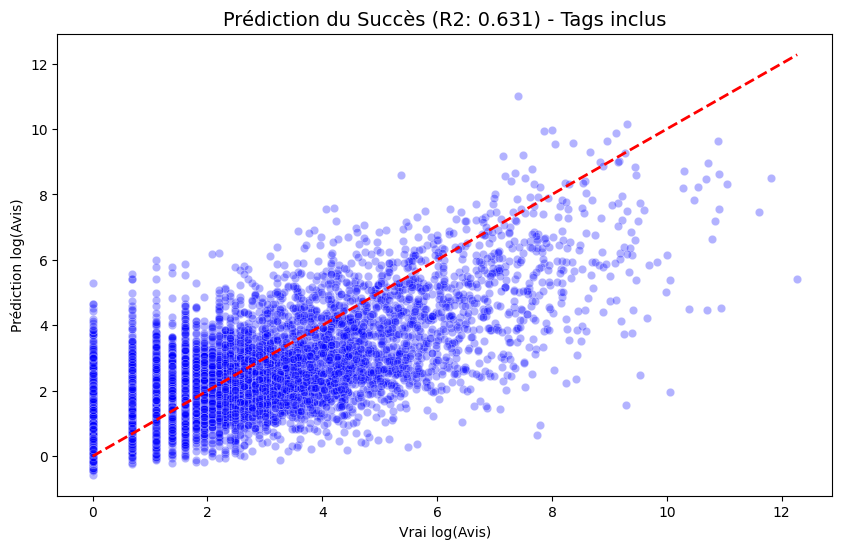

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement et Fusion
df = pd.read_parquet("DATA/data.parquet")
cluster = pd.read_parquet("DATA/steam_data_clustered.parquet")
df = pd.merge(df, cluster, on="app_id")

# 2. Sélection Intelligente des Colonnes
# On prend tout ce qui est textuel pour donner un max de contexte à CatBoost
cols_text = ["tags_utilisateurs"]
cols_num = ["donnees_commerciales_prix_initial", "contenu_et_fonctionnalites_nombre_succes"]
cols_cat = ["support_manette"] # On peut aussi mettre Cluster ici si on veut

# Vérification que les colonnes existent
features = cols_num + cols_cat + [c for c in cols_text if c in df.columns]
target = "evaluations_avis_utilisateurs_total"

# 3. Nettoyage
data = df.dropna(subset=[target]).copy()

# Fonction pour transformer les listes (tags) en phrases simples
def clean_text_col(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(i) for i in x])
    return str(x) if pd.notna(x) else ""

# Appliquer le nettoyage sur toutes les colonnes texte
for c in cols_text:
    if c in data.columns:
        data[c] = data[c].apply(clean_text_col)

data["support_manette"] = data["support_manette"].astype(str)

# 4. Préparation X et Y (Log)
X = data[features]
y_log = np.log1p(data[target])

# 5. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 6. Entraînement CatBoost (Le modèle final)
cb = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=7,                  # Un peu plus profond pour capturer les interactions Tags <-> Prix
    text_features=[c for c in cols_text if c in df.columns],
    cat_features=cols_cat,
    verbose=200,
    early_stopping_rounds=100,
    task_type="CPU"
)

cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 7. Affichage des résultats pour ton rapport
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(y_test, y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
# Feature Importance (Pour ton rapport : "Qu'est-ce qui fait un hit ?")
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))

# 8. Graphique "Preuve de réussite"
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - Tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()

Test catboost text

In [36]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# 1. On recharge TOUT pour être sûr d'avoir le texte
df = pd.read_parquet("DATA/data.parquet")
cluster = pd.read_parquet("DATA/steam_data_clustered.parquet")
df = pd.merge(df, cluster, on="app_id")

# 2. On prépare les données (Texte + Prix + Manette)
# On choisit la description courte si la détaillée est trop lourde pour ta RAM
col_texte = "description_courte_x" # Essaie "description_courte_x" si ça plante

# Nettoyage minimal
df[col_texte] = df[col_texte].fillna("")
df["support_manette"] = df["support_manette"].astype(str) # CatBoost aime les strings pour les catégories

features = ["support_manette", "donnees_commerciales_prix_initial", "contenu_et_fonctionnalites_nombre_succes", "cluster_BERTopic", col_texte]
target = "evaluations_avis_utilisateurs_total"

# On filtre les lignes sans target
df = df.dropna(subset=[target])

X = df[features]
y_log = np.log1p(df[target]) # On garde le log pour l'entraînement

# 3. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 4. CatBoost avec gestion du Texte
cb = CatBoostRegressor(
    iterations=1000,          # Raisonnable pour commencer
    learning_rate=0.05,
    depth=10,
    text_features=[col_texte], # <--- C'est ici que ça se joue
    cat_features=["support_manette", "cluster_BERTopic"],
    verbose=100,
    early_stopping_rounds=50,
    task_type="CPU"           # Mets "GPU" si tu peux, ça ira 10x plus vite
)

print(f"Entraînement sur le texte : {col_texte}...")
cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 5. Résultats
y_pred_log = cb.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

print("--- RÉSULTATS CATBOOST TEXTE ---")
print(f"R2 (Log Space) : {r2_score(y_test, y_pred_log):.4f}")
print(f"R2 (Real Space): {r2_score(y_test_real, y_pred):.4f}")

Entraînement sur le texte : description_courte_x...
0:	learn: 1.9971252	test: 1.9855596	best: 1.9855596 (0)	total: 1.02s	remaining: 17m 2s
100:	learn: 1.4407260	test: 1.4620489	best: 1.4620489 (100)	total: 1m 24s	remaining: 12m 34s
200:	learn: 1.4137937	test: 1.4487522	best: 1.4487522 (200)	total: 2m 52s	remaining: 11m 23s
300:	learn: 1.3793622	test: 1.4379842	best: 1.4379842 (300)	total: 4m 16s	remaining: 9m 55s
400:	learn: 1.3510781	test: 1.4317178	best: 1.4317178 (400)	total: 5m 46s	remaining: 8m 37s
500:	learn: 1.3245997	test: 1.4277748	best: 1.4277374 (499)	total: 7m 12s	remaining: 7m 10s
600:	learn: 1.3009795	test: 1.4258483	best: 1.4258483 (600)	total: 8m 37s	remaining: 5m 43s
700:	learn: 1.2788432	test: 1.4239236	best: 1.4239236 (700)	total: 10m 4s	remaining: 4m 17s
800:	learn: 1.2583576	test: 1.4225349	best: 1.4225349 (800)	total: 11m 30s	remaining: 2m 51s
900:	learn: 1.2396449	test: 1.4216762	best: 1.4216379 (886)	total: 12m 57s	remaining: 1m 25s
999:	learn: 1.2218963	test: 1

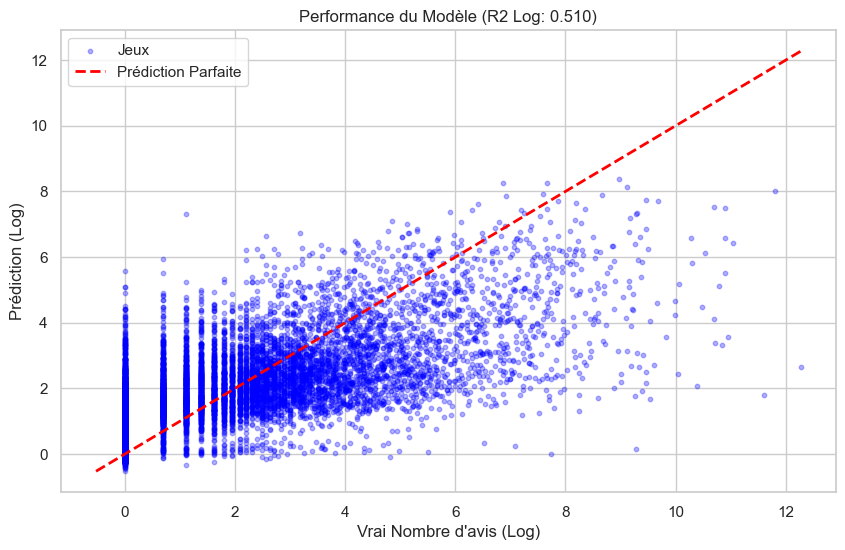

Exemples de prédictions :
                                  Titre  Vrai_Avis  Prediction
52857                      Nachtschicht          0           0
58473                      Taking Honey          0           4
4021                           Find Out         32           3
24775                   Astral Guardian          0          18
10459       Trivia Vault: Hockey Trivia         26          20
32494                 Tiny Force Deluxe          1          13
37095  Constellations: Beyond the edges          0           0
58170                 Loop! Loop! Sushi          0           0
4157                    Planar Conquest        239          13
58798        Ephemeral Art: Shapeweaver          0           5


2025-12-15 23:52:07,625 - INFO     - Executing shutdown due to inactivity...
2025-12-15 23:52:07,700 - INFO     - Executing shutdown...
2025-12-15 23:52:07,701 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# On configure le style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Nuage de points : Réel vs Prédit (en Log)
plt.scatter(y_test, y_pred_log, alpha=0.3, s=10, c='blue', label='Jeux')

# Ligne parfaite (y=x)
min_val = min(y_test.min(), y_pred_log.min())
max_val = max(y_test.max(), y_pred_log.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Prédiction Parfaite')

plt.xlabel("Vrai Nombre d'avis (Log)")
plt.ylabel("Prédiction (Log)")
plt.title(f"Performance du Modèle (R2 Log: {r2_score(y_test, y_pred_log):.3f})")
plt.legend()
plt.show()

# Exemple de lecture pour quelques jeux
results = pd.DataFrame({
    'Titre': df.loc[X_test.index, 'nom'] if 'nom' in df.columns else X_test.index,
    'Vrai_Avis': np.expm1(y_test).astype(int),
    'Prediction': np.expm1(y_pred_log).astype(int)
})

print("Exemples de prédictions :")
print(results.sample(10))

In [68]:
feature_importance = cb.get_feature_importance(prettified=True)
print(feature_importance)

                                 Feature Id  Importances
0         donnees_commerciales_prix_initial    51.163442
1                      description_courte_x    24.922412
2  contenu_et_fonctionnalites_nombre_succes    21.850031
3                           support_manette     1.097035
4                          cluster_BERTopic     0.967080


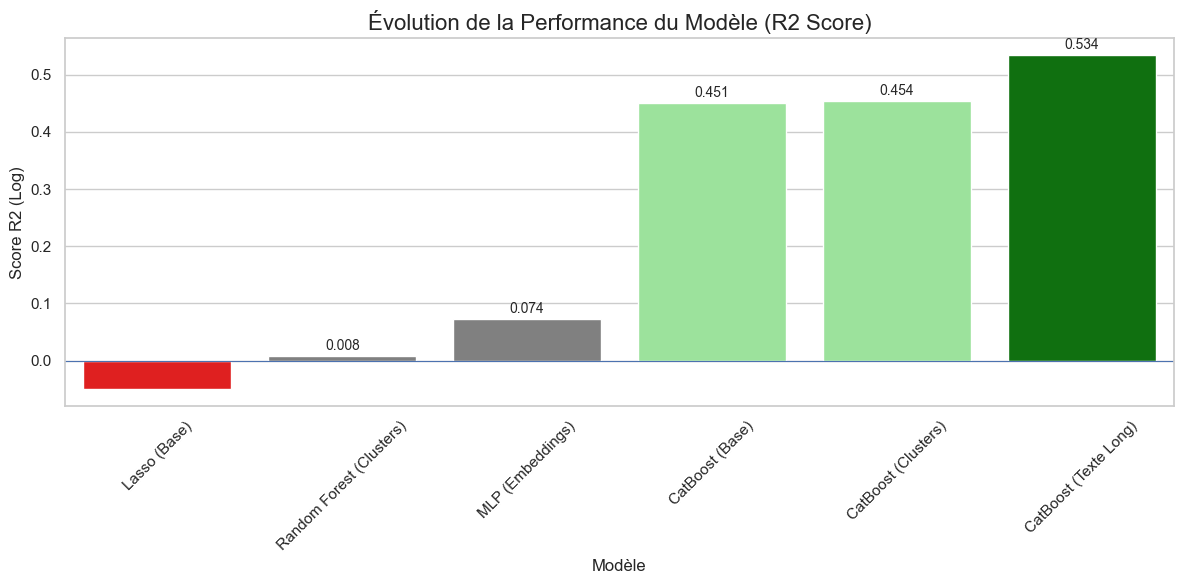

2025-12-16 08:49:53,483 - INFO     - Executing shutdown due to inactivity...
2025-12-16 08:49:53,845 - INFO     - Executing shutdown...
2025-12-16 08:49:53,846 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


In [39]:
# Tes résultats (approximatifs basés sur nos échanges)
results = pd.DataFrame({
    'Modèle': ['Lasso (Base)', 'Random Forest (Clusters)', 'MLP (Embeddings)','CatBoost (Base)','CatBoost (Clusters)', 'CatBoost (Texte Long)'],
    'R2 Score (Log Space)': [-0.05,0.008, 0.0736,0.451,0.454, 0.534],
    'Type': ['Echec', 'Baseline','Baseline','Baseline', 'Echec','Meilleur']
})

plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

colors = [
    'red' if x < 0 
    else 'grey' if x < 0.2 
    else 'lightgreen' if x < 0.52 
    else 'green'
    for x in results['R2 Score (Log Space)']
]

sns.barplot(
    data=results,
    x='Modèle',
    y='R2 Score (Log Space)',
    hue='Modèle',        
    palette=colors,
    legend=False
)

plt.title('Évolution de la Performance du Modèle (R2 Score)', fontsize=16)
plt.ylabel('Score R2 (Log)', fontsize=12)
plt.xticks(rotation=45)
plt.axhline(0, linewidth=0.8)

for i, v in enumerate(results['R2 Score (Log Space)']):
    if v > 0:
        plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()

0:	learn: 1.9958726	test: 1.9838649	best: 1.9838649 (0)	total: 243ms	remaining: 8m 5s
200:	learn: 1.2673193	test: 1.3015117	best: 1.3015117 (200)	total: 42.7s	remaining: 6m 22s
400:	learn: 1.1951886	test: 1.2646183	best: 1.2646183 (400)	total: 1m 48s	remaining: 7m 12s
600:	learn: 1.1490652	test: 1.2495814	best: 1.2495814 (600)	total: 2m 47s	remaining: 6m 29s
800:	learn: 1.1112980	test: 1.2401129	best: 1.2401129 (800)	total: 3m 28s	remaining: 5m 11s
1000:	learn: 1.0782085	test: 1.2333707	best: 1.2333653 (999)	total: 4m 29s	remaining: 4m 29s
1200:	learn: 1.0503722	test: 1.2283069	best: 1.2283069 (1200)	total: 5m 20s	remaining: 3m 33s
1400:	learn: 1.0241806	test: 1.2250174	best: 1.2250160 (1399)	total: 6m 8s	remaining: 2m 37s
1600:	learn: 1.0002773	test: 1.2220142	best: 1.2220142 (1600)	total: 6m 58s	remaining: 1m 44s
1800:	learn: 0.9783815	test: 1.2197128	best: 1.2196840 (1792)	total: 7m 43s	remaining: 51.3s
1999:	learn: 0.9579371	test: 1.2174960	best: 1.2174867 (1997)	total: 8m 26s	rema

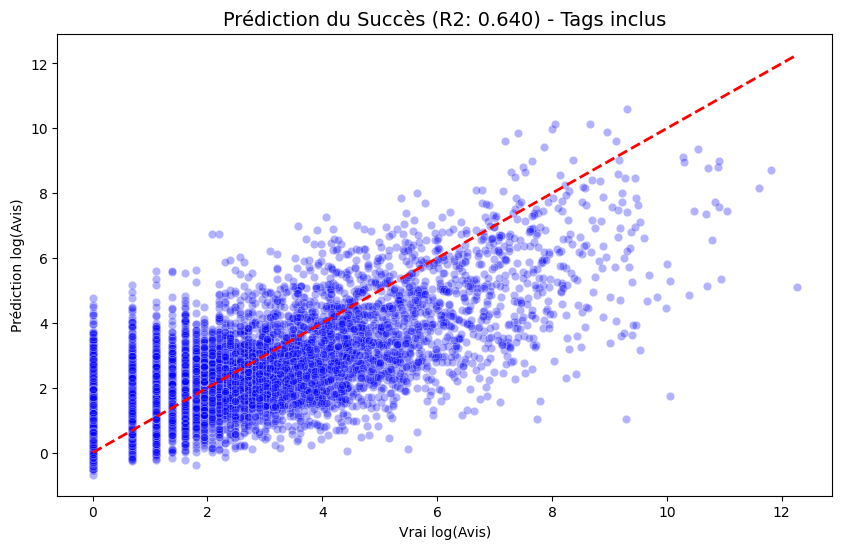

In [16]:
# 1. Chargement et Fusion
df = pd.read_parquet("DATA/data.parquet")
cluster = pd.read_parquet("DATA/steam_data_clustered.parquet")
df = pd.merge(df, cluster, on="app_id")

# 2. Sélection Intelligente des Colonnes
# On prend tout ce qui est textuel pour donner un max de contexte à CatBoost
cols_text = ["tags_utilisateurs", "description_detaillee", "genres", "categories"]
cols_num = ["donnees_commerciales_prix_initial", "contenu_et_fonctionnalites_nombre_succes"]
cols_cat = ["support_manette"] # On peut aussi mettre Cluster ici si on veut

# Vérification que les colonnes existent
features = cols_num + cols_cat + [c for c in cols_text if c in df.columns]
target = "evaluations_avis_utilisateurs_total"

# 3. Nettoyage
data = df.dropna(subset=[target]).copy()

# Fonction pour transformer les listes (tags) en phrases simples
def clean_text_col(x):
    if isinstance(x, (list, np.ndarray)):
        return " ".join([str(i) for i in x])
    return str(x) if pd.notna(x) else ""

# Appliquer le nettoyage sur toutes les colonnes texte
for c in cols_text:
    if c in data.columns:
        data[c] = data[c].apply(clean_text_col)

data["support_manette"] = data["support_manette"].astype(str)

# 4. Préparation X et Y (Log)
X = data[features]
y_log = np.log1p(data[target])

# 5. Split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 6. Entraînement CatBoost (Le modèle final)
cb = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=7,                  # Un peu plus profond pour capturer les interactions Tags <-> Prix
    text_features=[c for c in cols_text if c in df.columns],
    cat_features=cols_cat,
    verbose=200,
    early_stopping_rounds=100,
    task_type="CPU"
)

cb.fit(X_train, y_train, eval_set=(X_test, y_test))

# 7. Affichage des résultats pour ton rapport
y_pred_log = cb.predict(X_test)
score_r2 = r2_score(y_test, y_pred_log)

y_pred = np.expm1(y_pred_log)
print(f"\n🏆 SCORE FINAL (R2 Log) : {score_r2:.4f}")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
# Feature Importance (Pour ton rapport : "Qu'est-ce qui fait un hit ?")
imp = cb.get_feature_importance(prettified=True)
print("\nTop Facteurs de Succès :")
print(imp.head(10))

# 8. Graphique "Preuve de réussite"
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_log, alpha=0.3, color='blue')
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', lw=2)
plt.title(f"Prédiction du Succès (R2: {score_r2:.3f}) - Tags inclus", fontsize=14)
plt.xlabel("Vrai log(Avis)")
plt.ylabel("Prédiction log(Avis)")
plt.show()